We want to forecast day-ahead VaR risk measure using historical simulation method. The idea is to use VaR computed from a window of past observations as a VaR forecast for the next time period.

Recall that VaR is defined as: $VaR_\alpha(L)=\inf\{l \in \mathcal{R} \mid F_{L}(l) \geq \alpha\}$

Where L are losses for one period and $F_L$ is their distribution. $\alpha$ is the pre-specified probability that losses are less than VaR.

Above VaR definition suggests that VaR is essentially the $\alpha$ quantile of the loss distribution i.e. $VaR_\alpha(L) = q_\alpha(F_L)$ and sample quantile migh be a good estimate for VaR.

In the following basing on assumption that returns are i.i.d. we use VaR computed over a window of observations as a forecast for next day.

In [201]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [202]:
path = 'datasets/DAX_daily_prices.xlsx'
data = pd.read_excel(path)
data.columns = ['Date', 'DAX']
dates = pd.to_datetime(data['Date'], format='%Y-%m-%d')
prices = np.array(data["DAX"])[::-1] # as prices were ordered from newest to oldest
losses = - np.diff(np.log(prices)) # losses are defined as negative returns

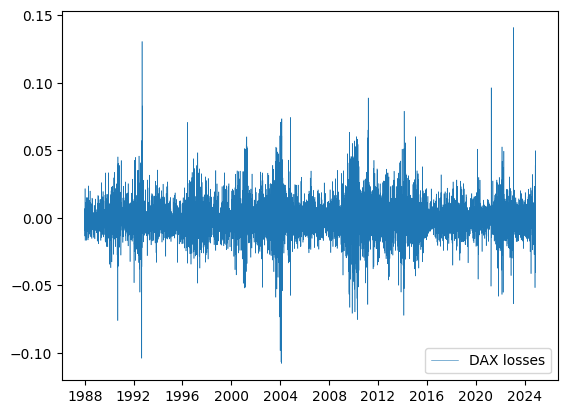

In [203]:
plt.figure()
plt.plot(dates[1:], losses, label='DAX losses', lw=0.4);
plt.legend()

Below we define a function that computes VaR in a rolling window fashion i.e. window of past observations is used to compute VaR which is taken as a forecast for day-ahead VaR. Additionally we want to find confidence interval for our VaR estimates. 

For confidence interval we are interested in: $\mathbf{P}(b_{lower} < q_\alpha(F) < b_{upper}) = p$

In this case we want centered conf. interval i.e.

$\mathbf{P}(b_{lower} \geq q_\alpha(F)) = \frac{1-p}{2} = \mathbf{P}(q_\alpha(F) \geq b_{upper})$

The idea is to choose $(X_{i:n}, X_{j:n})$ with $i \geq j$ for lower(i) and upper(j) bound respectively where $X_{k:n}$ denote in our case losses ordered descendingly.

Observe then that $\sum_{k=1}^n\mathbf{1}_{\{X_k \geq q_\alpha(F)\}} \sim Binom(n, 1-\alpha)$. We then have:

$\mathbf{P}(q_\alpha(F) \leq X_{i:n} = \mathbf{P}(\sum_{k=1}^n\mathbf{1}_{\{X_k \geq q_\alpha(F)\}} \geq i) = 1 - F_B(i-1)$

And similarly for upper bound:

$\mathbf{P}(X_{j:n} \leq q_\alpha(F)) = 1 - \mathbf{P}(q_\alpha(F) < X_{j:n}) = 1 - \mathbf{P}(\sum_{k=1}^n \mathbf{1}_{\{X_k > q_\alpha(F)\}} \geq j) = F_B(j-1)$

Inserting it into first equation and subtracting 1 on each side gives (for i):

$F_B(i-2) < \frac{1+p}{2} \leq F_B(i-1)$

And for j:

$F_B(j-1) \leq \frac{1-p}{2} < F_B(j)$

Solving for i and j using inverse of binomial distribution gives us indices of observations which we use as lower and upper bound:

$i = F_B^{-1}(\frac{1+p}{2}) + 1$

$j = F_B^{-1}(\frac{1-p}{2})$

Below we implement the above procedure.

In [204]:
def var_rolling(X, window, alpha, p=0):
    '''

    :param X: Losses
    :param window: Lengths of window to compute var
    :param alpha: Level for var
    :param p: Level for confidence interval of var (2-sided)
    :return: [var, l_bounds, u_bounds]
    '''
    N = len(X)
    # Create windows with data
    X_windows = np.zeros(shape=(N-window+1, window))
    for i in range(N-window+1): # should it be in range N-window+1???
        X_windows[i, :] = np.sort(X[i: i+window])[::-1] # losses sorted in descending order.

    # Compute var:
    vars = np.quantile(X_windows, alpha, axis=1, method='inverted_cdf')
    
    if p != 0:
        # Compute indices for confidence intervals based on Binomial(window, 1-alpha) distribution
        i_val_lower = int(1 + binom(window, 1-alpha).ppf((1+p)/2)) # e.g. p = 0.99 then i is indice for lower bound quantile ppf(0.995)
        j_val_upper = int(binom(window, 1-alpha).ppf((1-p)/2))
        # order statistics are defined starting with index 1. j could however, take value 0. We would then assign it to first order statistic.
        # Due to python indexing starting at 0 this is not significant.
        
        # compute bounds:
        l_bounds = X_windows[:, i_val_lower]
        u_bounds = X_windows[:, j_val_upper]

        return vars, l_bounds, u_bounds
    else:
        return vars
    
    return vars, l_bounds, u_bounds


We compute var, lower and upper bound in case of our dataset: DAX daily returns.

In [205]:
wind = 252
alpha = 0.99
var, lower_b, upper_b = var_rolling(losses, window=wind, alpha=alpha, p=0.99)

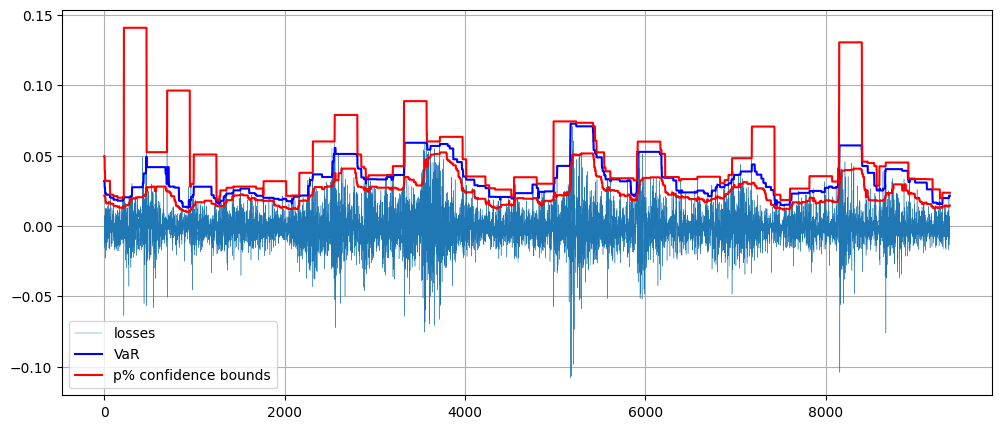

In [206]:
# Plot results:
plt.figure(figsize=(12, 5));
plt.plot(losses[wind:], label='losses', lw=0.3);
plt.plot(var, label='VaR', c='blue');
plt.plot(lower_b, label='p% confidence bounds', c='red');
plt.plot(upper_b, c='red');
plt.grid();
plt.legend();

Finally we asses the performance of VaR as forecast for day-ahead VaR. In this case $\alpha = 0.99$ thus we expect that loss greater than VaR will occur only in 1% of cases. We compare this with empirical data:

In [207]:
ratio_exceedences = np.mean(np.where(var[:-1] < losses[wind:], 1, 0))
print("VaR is exceeded in: ", ratio_exceedences*100, "% of times")
print("Day-ahead out-of-sample VaR99% forecast is: ", var[-1])

VaR is exceeded in:  1.4078498293515358 % of times
Day-ahead out-of-sample VaR99% forecast is:  0.021567148091243382


This suggests that VaR as computed above might be slightly undereestimated as we have 0.4% more losses greater than expected.

If we believe VaR is accurately estimated it can be used to determine buffer capital for next day. If we hold e.g. 1000000 invested in the asset then the buffer capital becomes: 1 000 000 * 0.0215 = 21 500

## Part 2
We want to prepare a similar scheme now for Expected Shortfall.

Basing on the definition i.e. $ES_{\alpha}(L) = \mathbf{E}[L \mid L \geq VaR_\alpha(L)]$, $ES_\alpha$ is simply the average losses given that they exceed VaR.

We thus define a function that computes the ES in similar fashion as for VaR where ES is computed using average losses above VaR. The confidence interval can also be constructed for which we will use bootstrapping.

In [208]:
def ES_rolling(X, window, alpha, p, B):
    """
    X - vector with losses
    window - window size for computing ES
    alpha - level for ES
    p - confidence interval level
    B - number of bootstraps
    """
    
    # Create windows:
    N = len(X)
    X_wind_sort = np.zeros(shape=(N-window+1, window))
    for i in range(N-window+1):
        X_wind_sort[i, :] = np.sort(X[i:i+window])

    
    # Compute Expected Shortfalls:
    var_index = int(window*alpha)
    ES = np.mean(X_wind_sort[:, var_index:], axis=1)
    # Compute confidence intervals using B bootstrap samples:
    ES_lower = np.zeros(N-window+1)
    ES_upper = np.zeros(N-window+1)
    for i in range(N-window+1):
        boot_samples = np.random.choice(X_wind_sort[i, :], size=(B, window), replace=True)
        boot_samples.sort(axis=1)
        ES_sample = np.mean(boot_samples[:, var_index:], axis=1)
        ES_lower[i], ES_upper[i] = np.quantile(ES_sample, [(1-p)/2, (1+p)/2])

    
    # Testing ES: Unconditional Coverage Test: Acerbi, Szekely 2014 (not returned)
    # Compute test statistic:
    #vars = var_rolling(X, window, alpha)
    #id_mask = np.where(X[252:] > vars[:-1], 1, 0)
    #Z = 1 + np.mean(id_mask*X[252:]/(alpha*ES[:-1]))
    
    return ES, ES_lower, ES_upper

In [209]:
ES, ES_l, ES_u = ES_rolling(losses, 252, 0.99, 0.99, 1000)

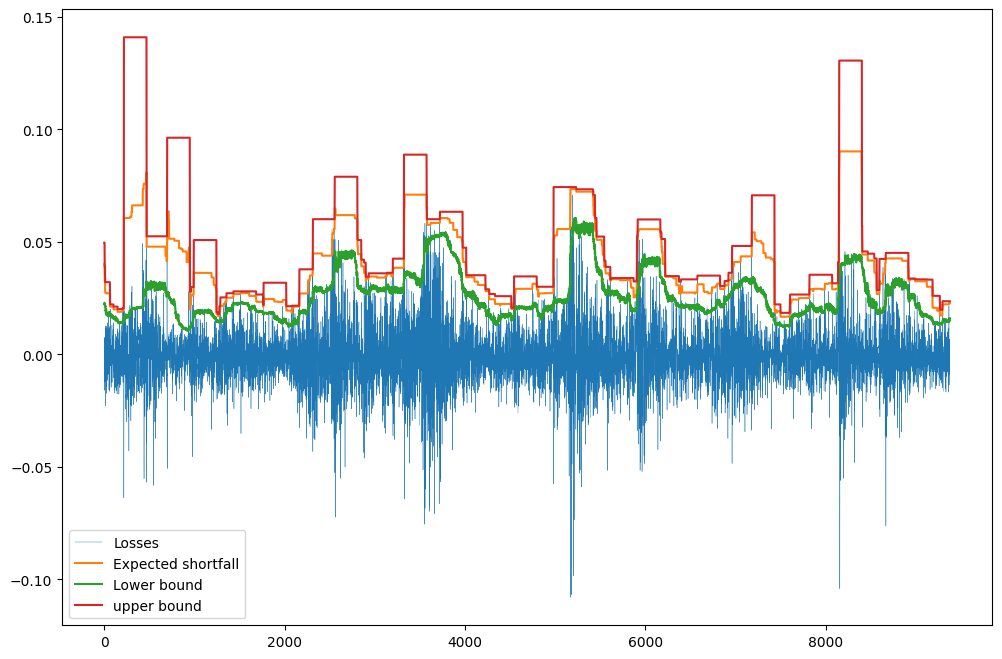

In [211]:
plt.figure(figsize=(12, 8))
plt.plot(losses[252:], lw=0.3, label='Losses')
plt.plot(ES, label='Expected shortfall')
plt.plot(ES_l, label='Lower bound')
plt.plot(ES_u, label='upper bound')
plt.legend()

Backtesting ES is non-trivial. We can still look as previousely how often losses exceed ES however we only know that it will be less often than for VaR as by definition ES is at least as large as VaR.

In [212]:
es_exceedences = np.mean(np.where(losses[252:] > ES[:-1], 1, 0))
print(es_exceedences)

0.0075725255972696245


Another way to test ES can be found in Acerbi, Szekely (2014) - 'Backtesting Expected Shortfall'. Z (below) can be used as in unconditional test for ES.

$Z = 1 + \frac{1}{n} \sum_{i=1}^n \frac{X_n \mathbf{1}_{X_n \geq VaR_\alpha(L_n)}}{ES_\alpha(L_n)\alpha}$

The alternative hypothesis for this test is that estimated ES is lower than true ES together with estimated VaR being lower than true VaR.


The probelm with this statistic is that distribution under H0 is not know. As a solution we can implement bootstrapping again to generate the distribution of Z and then choose confidence interval.